In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Loading test output from the model and converting to time index

filename1 = r'Brunei_Champion7_GT4_tst_pred_01Mar2019_01Jul2019_w1d_m3hr.csv'
#filename2 = "Brunei_Champion7_GT4_tst_pred_01Apr2019-01July2019.csv"

#dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d %H:%M')
df = pd.read_csv(filename1, parse_dates = ['timestamp'])
df.set_index('timestamp', inplace = True)
df['date'] = df.index


In [4]:
# Changing -1 to 1 and 1 to 0 [1 denotes anomaly, 0 denotes normal]

df.prediction = df.prediction.replace(1, 0)
df.prediction = df.prediction.replace(-1, 1)

df['anomaly'] = 0
df.loc[(df['system_status'] == 'online') & (df['prediction'] == 1), 'anomaly'] = 1

df['normal'] = 0
df.loc[(df['system_status'] == 'online') & (df['prediction'] == 0), 'normal'] = 1

df['sys_status'] = 0
df.loc[(df['system_status'] == 'online'), 'sys_status'] = 1
df.loc[(df['system_status'] == 'offline'), 'sys_status'] = 0

df['flips'] = 0
df.loc[(df['system_status'] == 'online') & (df['alert'] == 1) & (df['prediction'] == 1), 'flips'] = 1

df['counter_flips'] = 0
df.loc[(df['system_status'] == 'online') & (df['alert'] == 0) & (df['prediction'] == 1), 'counter_flips'] = 1


In [5]:
## Creating results dataframe

resultsdf = df[['anomaly','flips','counter_flips', 'normal', 'sys_status']].resample('W').sum()
resultsdf.columns = ['anomaly_count','flips_count','counter_flips_count','model_uptime_count','online_status_count']

x = df[['prediction', 'sys_status']].resample('W').count()

resultsdf['Total_counts'] = x['prediction']

resultsdf['anomaly_ratio'] = (resultsdf['anomaly_count'] / resultsdf['Total_counts']).round(2)
resultsdf['flips_ratio'] = (resultsdf['flips_count'] / resultsdf['Total_counts']).round(2)
resultsdf['counter_flips_ratio'] = (resultsdf['counter_flips_count'] / resultsdf['Total_counts']).round(2)
resultsdf['model_uptime_ratio'] = (resultsdf['model_uptime_count'] / resultsdf['Total_counts']).round(2)
resultsdf ['machine availability'] =  ((resultsdf['online_status_count']/ (x['sys_status'])) * 100).round(2)



In [6]:
#resultsdf.drop(resultsdf.tail(1).index, inplace = True)
len(resultsdf) #datapoints  

19

In [28]:
resultsdf.index

DatetimeIndex(['2019-03-03', '2019-03-10', '2019-03-17', '2019-03-24',
               '2019-03-31', '2019-04-07', '2019-04-14', '2019-04-21',
               '2019-04-28', '2019-05-05', '2019-05-12', '2019-05-19',
               '2019-05-26', '2019-06-02', '2019-06-09', '2019-06-16',
               '2019-06-23', '2019-06-30'],
              dtype='datetime64[ns]', name='timestamp', freq='W-SUN')

<IPython.core.display.Javascript object>


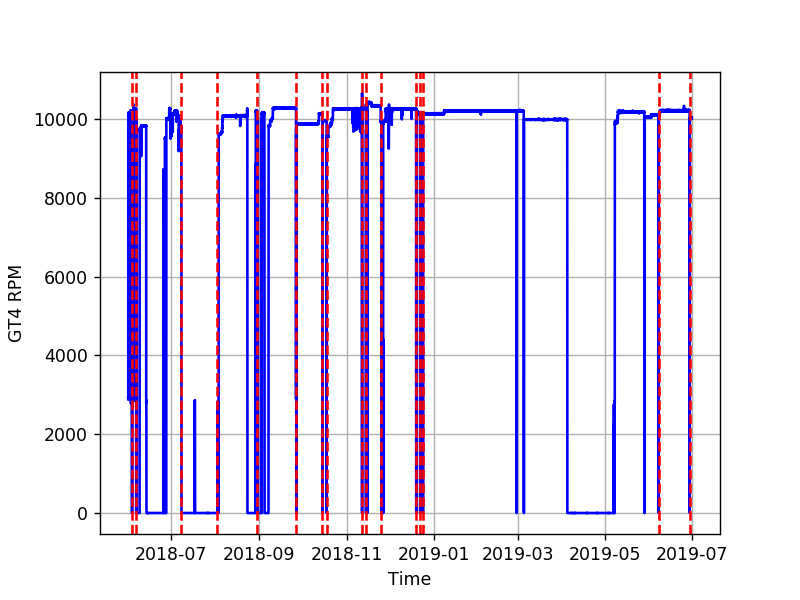

In [7]:
# Plotting entire dataset 

%matplotlib notebook

#dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
#pdf = pd.read_csv(r'gt4_master_data.csv', parse_dates=['timestamp'], date_parser = dateparse)
pdf = pd.read_csv(r'gt4_master_data.csv', parse_dates = ['timestamp'])
pdf.set_index('timestamp', inplace = True)

# Loading events_log 

dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
dffailure = pd.read_excel(r'GT4-downtime.xlsx', parse_dates = ['Trip Start Date'], date_parser = dateparse)
pdf = pdf[pdf.index <= resultsdf.index[-1]]

fig, ax1 = plt.subplots()

ax1.plot(pdf['CPCX07-DCS-GT4_XZA4754_NEW'], 'b-', label = 'RPM')
ax1.set_xlabel('Time')
ax1.set_ylabel('GT4 RPM')
#ax1.legend()
ax1.grid(True)
for cnt in range(len(dffailure)):
    ax1.axvline(x = dffailure.loc[dffailure.index[cnt],'Trip Start Date'], color = 'r', linestyle = '--')

plt.xticks(fontsize = 10)
plt.show()


In [22]:
# Reloading the failure dataframe

dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
dffailure = pd.read_excel(r'GT4-downtime.xlsx', parse_dates = ['Trip Start Date'], date_parser = dateparse)
dffailure = dffailure[dffailure['Trip Start Date'] >= resultsdf.index[0]]
dffailure = dffailure[dffailure['Trip Start Date'] <= resultsdf.index[-1]]


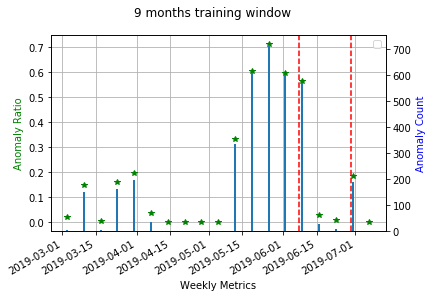

In [23]:
# Create anomaly ratio plot

fig, ax1 = plt.subplots()
fig.autofmt_xdate(bottom = 0.2, rotation = 30)
fig.suptitle('9 months training window', fontsize = 12)

ax2 = ax1.twinx()
ax1.plot(resultsdf['anomaly_ratio'], 'g*', label = 'Ratio')
ax2.bar(resultsdf.index,resultsdf['anomaly_count'], label = 'Count')
ax1.set_xlabel('Weekly Metrics')
ax1.set_ylabel('Anomaly Ratio', color = 'g')
ax2.set_ylabel('Anomaly Count', color = 'b')
ax1.grid(True)
#ax2.grid('off')
#fig.legend()
ax1.legend('Ratio','Count')
for cnt in range(len(dffailure)):
    ax1.axvline(x = dffailure.loc[dffailure.index[cnt],'Trip Start Date'], color = 'r', linestyle = '--')

#plt.xticks(fontsize = 8)
plt.show() 

<IPython.core.display.Javascript object>


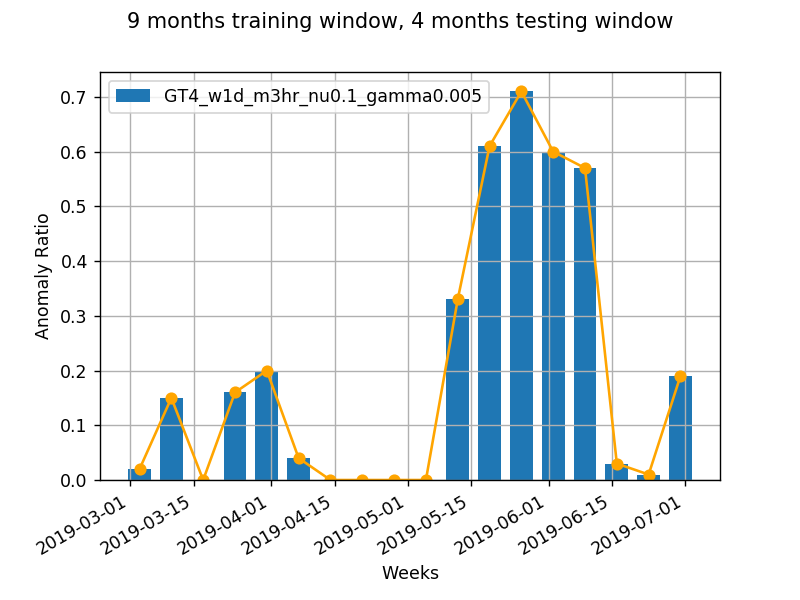

In [29]:
%matplotlib notebook

fig, ax = plt.subplots()
fig.autofmt_xdate(bottom = 0.2, rotation = 30)
fig.suptitle('9 months training window, 4 months testing window', fontsize = 12)

plt.bar(resultsdf.index, resultsdf['anomaly_ratio'], width = 5.0, label = "GT4_w1d_m3hr_nu0.1_gamma0.005")
ax.set_xlabel('Weeks')
ax.set_ylabel('Anomaly Ratio')
plt.plot(resultsdf.index, resultsdf['anomaly_ratio'], '-o', color='orange')
ax.grid()
ax.legend()

#z = np.polyfit(resultsdf.index, resultsdf['anomaly_ratio'], 1)
#p = np.poly1d(z)

#plt.plot(resultsdf.index, p(resultsdf.index), 'm-')

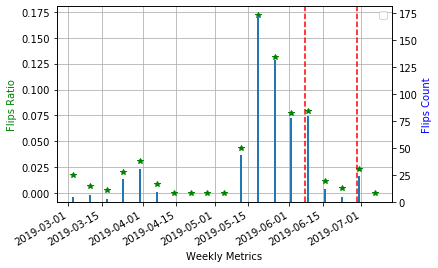

In [24]:
# Create flips ratio plot

%matplotlib inline

fig, ax1 = plt.subplots()
fig.autofmt_xdate(bottom = 0.2, rotation = 30)

ax2 = ax1.twinx()
ax1.plot(resultsdf['flips_ratio'], 'g*', label = 'Ratio')
ax2.bar(resultsdf.index, resultsdf['flips_count'], label = 'Count')

ax1.set_xlabel('Weekly Metrics')
ax1.set_ylabel('Flips Ratio', color = 'g')
ax2.set_ylabel('Flips Count', color = 'b')
ax1.grid(True)
#ax2.grid('off') 
#fig.legend()
ax1.legend('Ratio','Count')
for cnt in range(len(dffailure)):
    ax1.axvline(x = dffailure.loc[dffailure.index[cnt],'Trip Start Date'], color = 'r', linestyle = '--')


plt.show()

<IPython.core.display.Javascript object>


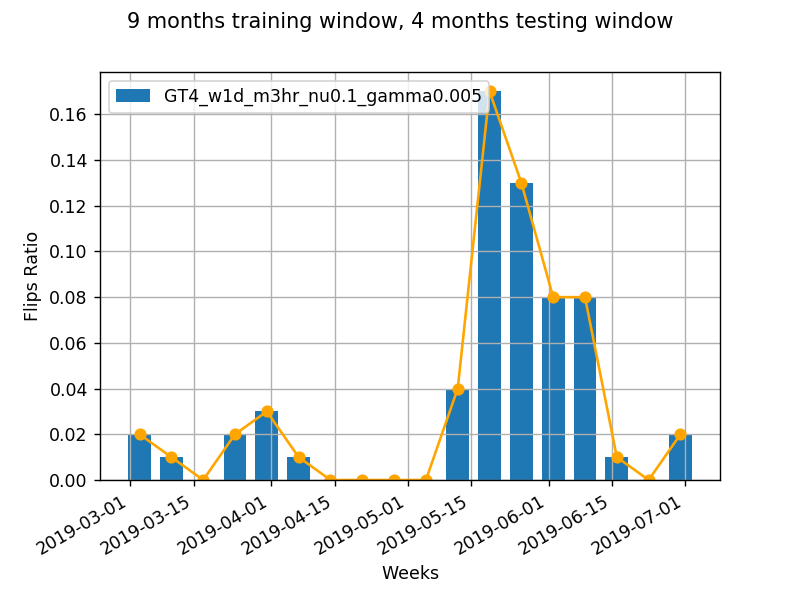

In [9]:
%matplotlib notebook

fig, ax = plt.subplots()
fig.autofmt_xdate(bottom = 0.2, rotation = 30)
fig.suptitle('9 months training window, 4 months testing window', fontsize = 12)

plt.bar(resultsdf.index, resultsdf['flips_ratio'], width = 5.0, label = "GT4_w1d_m3hr_nu0.1_gamma0.005")
ax.set_xlabel('Weeks')
ax.set_ylabel('Flips Ratio')
plt.plot(resultsdf.index, resultsdf['flips_ratio'], '-o', color = 'orange')
ax.grid()
ax.legend()

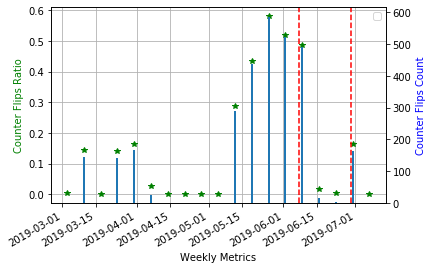

In [25]:
# Create counter_flips ratio plot

fig, ax1 = plt.subplots()
fig.autofmt_xdate(bottom = 0.2, rotation = 30)

ax2 = ax1.twinx()
ax1.plot(resultsdf['counter_flips_ratio'], 'g*',label = 'Ratio')
ax2.bar(resultsdf.index, resultsdf['counter_flips_count'], label = 'Count')

ax1.set_xlabel('Weekly Metrics')
ax1.set_ylabel('Counter Flips Ratio', color = 'g')
ax2.set_ylabel('Counter Flips Count', color = 'b')
ax1.grid(True)
#ax2.grid('off')
#fig.legend()
ax1.legend('Ratio','Count')
for cnt in range(len(dffailure)):
    ax1.axvline(x = dffailure.loc[dffailure.index[cnt],'Trip Start Date'], color = 'r', linestyle = '--')


plt.show()

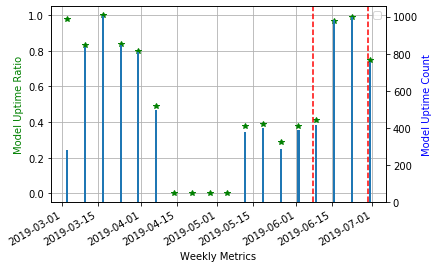

In [41]:
# Create model_uptime_ratio plot

%matplotlib inline

fig, ax1 = plt.subplots()
fig.autofmt_xdate(bottom = 0.2, rotation = 30)

ax2 = ax1.twinx()
ax1.plot(resultsdf['model_uptime_ratio'], 'g*', label = 'Ratio')
ax2.bar(resultsdf.index, resultsdf['model_uptime_count'], label = 'Count')

ax1.set_xlabel('Weekly Metrics')
ax1.set_ylabel('Model Uptime Ratio', color = 'g')
ax2.set_ylabel('Model Uptime Count', color = 'b')
ax1.grid(True)
#ax2.grid('off') 
#fig.legend()
ax1.legend('Ratio','Count')
for cnt in range(len(dffailure)):
    ax1.axvline(x = dffailure.loc[dffailure.index[cnt],'Trip Start Date'], color = 'r', linestyle = '--')


plt.show()

<IPython.core.display.Javascript object>


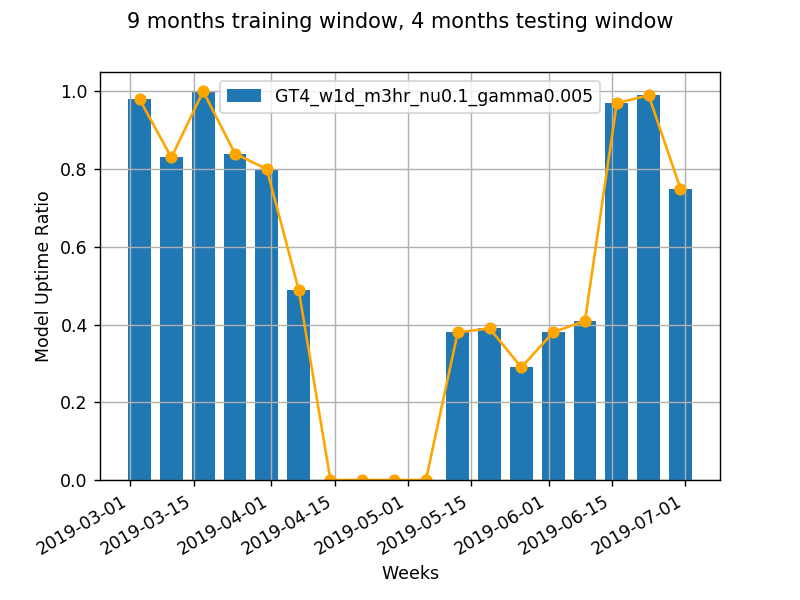

In [10]:
%matplotlib notebook

fig, ax = plt.subplots()
fig.autofmt_xdate(bottom = 0.2, rotation = 30)
fig.suptitle('9 months training window, 4 months testing window', fontsize = 12)

plt.bar(resultsdf.index, resultsdf['model_uptime_ratio'], width = 5.0, label = "GT4_w1d_m3hr_nu0.1_gamma0.005")
ax.set_xlabel('Weeks')
ax.set_ylabel('Model Uptime Ratio')
plt.plot(resultsdf.index, resultsdf['model_uptime_ratio'], '-o', color = 'orange')
ax.grid()
ax.legend()

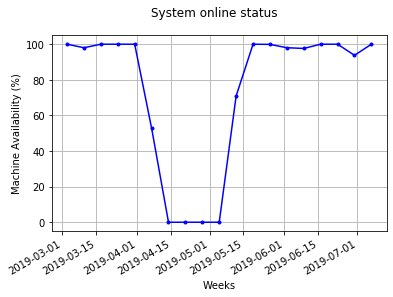

In [9]:
fig, ax = plt.subplots()
fig.autofmt_xdate(bottom = 0.2, rotation = 30)
fig.suptitle('System online status', fontsize = 12)

ax.plot(resultsdf['machine availability'], linestyle = '-', marker = '.', color = 'b')

ax.set_xlabel('Weeks')
ax.set_ylabel('Machine Availability (%)')
ax.grid(True)
#fig.legend('')

plt.show()

In [14]:
#resultsdf.head(10)

In [45]:
#resultsdf.to_csv('results.csv')

In [48]:
# Validate counts from the test data output file (monthly)

df[['anomaly','flips','counter_flips', 'normal', 'sys_status']].resample('M').sum()

,anomaly,flips,counter_flips,normal,sys_status
timestamp,,,,,
2019-03-31,520,67,453,3780,4300
2019-04-30,36,9,27,497,533
2019-05-31,2090,403,1687,1340,3430
2019-06-30,970,145,825,3263,4233
2019-07-31,0,0,0,1,1
